In [3]:
from potential_initialization import *
from trap_model import *
%load_ext autoreload
%autoreload 2
# 缓存pseudo potential在一个字典中，若在调试时修改了trap_model的定义可以快速初始化
pbi= dict()

In [4]:
# 设置需要计算势场的区域
shuttle_range = [[-1, 1], [-0.1, 0.1], [0.08, 0.2]]
stepsize = 0.01
# rf电压和频率需要提前设置
V_rf = 50
omega_rf = 2 * np.pi * 16e6
# 初始化trap_model类型
bowtie = trap_model("bowtie_ie5", V_rf, omega_rf, shuttle_range, stepsize, pbi, regenerate=False)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [5]:
bowtie.plot(electrodode=[6,7,8])

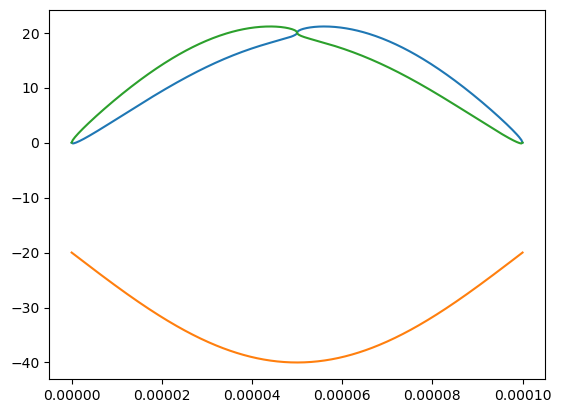

In [6]:
T=  0.0001
tspan = np.linspace(0,T, 400)

U0 = 20 * np.sin(tspan/T * np.pi)

Uc = -U0 - 20

Ud = 6 * np.sin(tspan/T * np.pi * 2)

Ud = np.sign(Ud) * np.abs(Ud) ** 0.5

plt.plot(tspan, U0-Ud)
plt.plot(tspan, Uc)
plt.plot(tspan, U0+Ud)

In [7]:
U = np.zeros((400, bowtie.nparts))
U[:, 7] = U[:, 2] = U0-Ud
U[:, 11] = U[:, 9] = Uc
U[:, 3] = U[:, 6] = U0+Ud

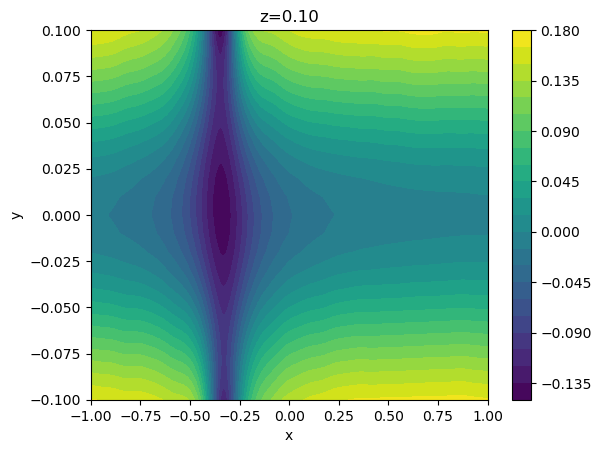

In [9]:
bowtie.plot_slice(z=0.1, voltage=U[100])

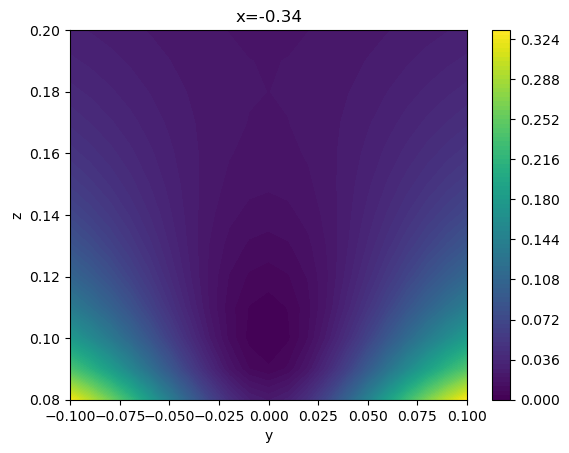

array([-0.34      , -0.0005472 ,  0.10055789])

In [14]:
bowtie.plot_slice(x=-0.34, voltage=np.zeros(bowtie.nparts))
bowtie.rf_null_point(-0.34)

In [255]:
bowtie.rf_null_point(-0.34)

array([-0.34      , -0.0005472 ,  0.10055789])

In [256]:
pos = bowtie.position(U[100], -0.34)
pos

array([[-3.38626525e-01,  1.55222713e-05,  1.04579758e-01]])

In [261]:
Ut  = np.zeros(bowtie.nparts)
U0 = 0
Uc = -5
Ud = 5

Ut[7] = Ut[2] = U0-Ud
Ut[11] = Ut[9] = Uc
Ut[3] = Ut[6] = U0+Ud

bowtie.reset_rf(100, 2 * np.pi * 16e6)
pos = bowtie.position(Ut, -0.344)
print(pos)
bowtie.freq(pos, Ut, rotate=True)

[[-0.33915549 -0.0004408   0.10361994]]


(array([0.21703857, 1.67662279, 1.57814412]),
 array([[-0.99967081,  0.02559681, -0.00175149],
        [ 0.02552581,  0.999138  ,  0.03273657],
        [-0.00258793, -0.03268109,  0.99946248]]))

In [46]:
tspan, X = bowtie.split_motion(-0.34, T, U)

In [50]:
import numpy as np
import plotly.graph_objects as go


# 提取每个粒子的 x, y, z 坐标
x1, y1, z1 = X[0], X[1], X[2]  # 第一个粒子
x2, y2, z2 = X[3], X[4], X[5]  # 第二个粒子

# 创建图形对象
fig = go.Figure()

# 添加第一个粒子的轨迹
fig.add_trace(go.Scatter3d(x=x1, y=y1, z=z1,
                           mode='lines',
                           name='Particle 1',
                           marker=dict(
                               size=4,                # 点的大小
                               color=tspan,           # 使用 tspan 作为颜色数据
                               colorscale='Viridis',  # 颜色渐变方案
                               colorbar=dict(title='Time')  # 颜色条标题
                           ),
                           line=dict(
                               color=tspan,           # 使用 tspan 作为线颜色数据
                               colorscale='Viridis',  # 线的颜色渐变方案
                               width=2)))

# 添加第二个粒子的轨迹
fig.add_trace(go.Scatter3d(x=x2, y=y2, z=z2,
                           mode='lines',
                           name='Particle 2',
                           marker=dict(
                               size=4,
                               color=tspan,
                               colorscale='Viridis',
                               colorbar=dict(title='Time')
                           ),
                           line=dict(
                               color=tspan,
                               colorscale='Viridis',
                               width=2)))

# 更新布局
fig.update_layout(title='3D Trajectories of Two Particles with Time-based Color Gradient',
                  scene=dict(
                      xaxis_title='X Axis',
                      yaxis_title='Y Axis',
                      zaxis_title='Z Axis'
                  ))

# 显示图形
fig.show()

Text(0, 0.5, '$\\beta (V/mm^4)$')

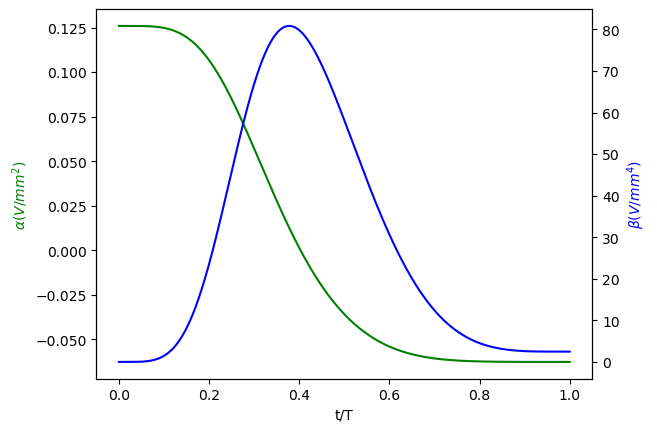

In [12]:

import shuttle_protocols 
import matplotlib.pyplot as plt
import numpy as np
fig, ax1 = plt.subplots()

s = np.linspace(0, 1, 1000)
a, b, d = shuttle_protocols.split_sta_palmero(s, f0=0.06)
ax2 = ax1.twinx()
ax1.plot(s, a/2, 'g-')
ax2.plot(s, b/24, 'b-')

ax1.set_xlabel('t/T')
ax1.set_ylabel(r'$\alpha (V/mm^2)$ ', color='g')
ax2.set_ylabel(r'$\beta (V/mm^4)$', color='b')

In [3]:
# 如果是在右半部分split，要求相对于split电极对称的电极拥有相同的电压，并且有两个固定为2V的endcap电极

gi, cons, fixed = dict(), dict(), dict()

max_v=10000

for p in bowtie.pairs:
    if p == "rf" or p == "ground":
        continue
    l, r = bowtie.pairs[p]
    if p>14 and p<=19:
        gi[l] = 28-p
        gi[r] = 28-p
    elif p>=9:
        gi[l] = p
        gi[r] = p
        if p==9:
            fixed[p]=2
        else:
            cons[p] = (-max_v, max_v)
gc = group_constrain_info(fixed, gi, cons)

In [24]:
# 如果是在左半部分split，要求相对于split电极对称的电极拥有相同的电压，并且有两个固定为2V的endcap电极

gi, cons, fixed = dict(), dict(), dict()

max_v=10000

for p in bowtie.pairs:
    if p == "rf" or p == "ground":
        continue
    l, r = bowtie.pairs[p]
    if p>7 and p<11:
        # gi[l] = 14-p
        # gi[r] = 14-p
        gi[l] = p
        gi[r] = p
        cons[p] = (-max_v, max_v)
    elif p>3 and p <=7:
        gi[l] = p
        gi[r] = p
        cons[p] = (-max_v, max_v)
    elif p==3:
        gi[l] = p
        gi[r] = p
        fixed[p]=0
    elif p==11:
        gi[l]=p
        gi[r]=p
        fixed[p]=1.2
gc = group_constrain_info(fixed, gi, cons)

In [25]:
2e6 * (0.06/0.5)**(10/3)/24

71.0269077407175

0it [00:00, ?it/s]

0.0002573071233862675
0.0002570204691858359
0.00025871303445099104
0.0002957742477305006
0.0006692880017506042
0.002760859068226482
0.010235098068503999
0.02878697947917433
0.05774455641370213
0.06639725398157074
0.027069087542611565
0.006081831766112702
0.003564470978756731
0.003372491788980685
0.0033856634392812686
0.0033501328945039995
0.003211706908147859
0.002981731187856749
0.0027000971433217133
0.002412165377452196
0.002156031902391303
0.0019580870612039606
0.0018325536959130976
0.0017843764169606314
0.0017785791775199145
0.001826980414084054
0.0019380762741996636
0.0020777881892586466
0.002199462799924633
0.0022518347721882503
0.00219371630443589
0.002009064476343611
0.0017208778137943145
0.0013767304225668102
0.0010329030821526512
0.0007339191561695898
0.0005038118519525125
0.0003459627283571839
0.00024570954602901697
0.00018615530656492305


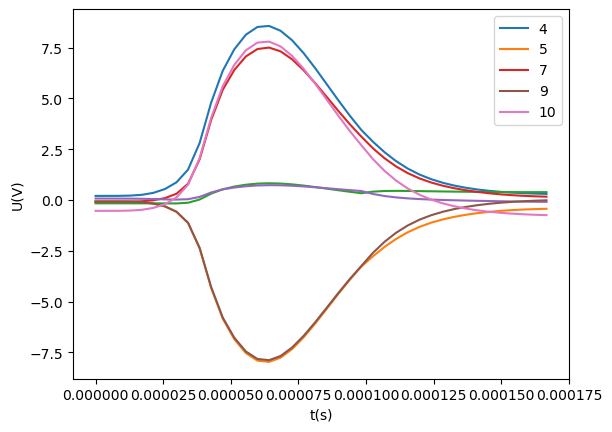

In [26]:
# 计算电压随时间变化关系
T, V = bowtie.optimize_splitting_profile(-0.34, gc=gc, max_v=100000, f0=0.06, top_nearest=9, deg=7)

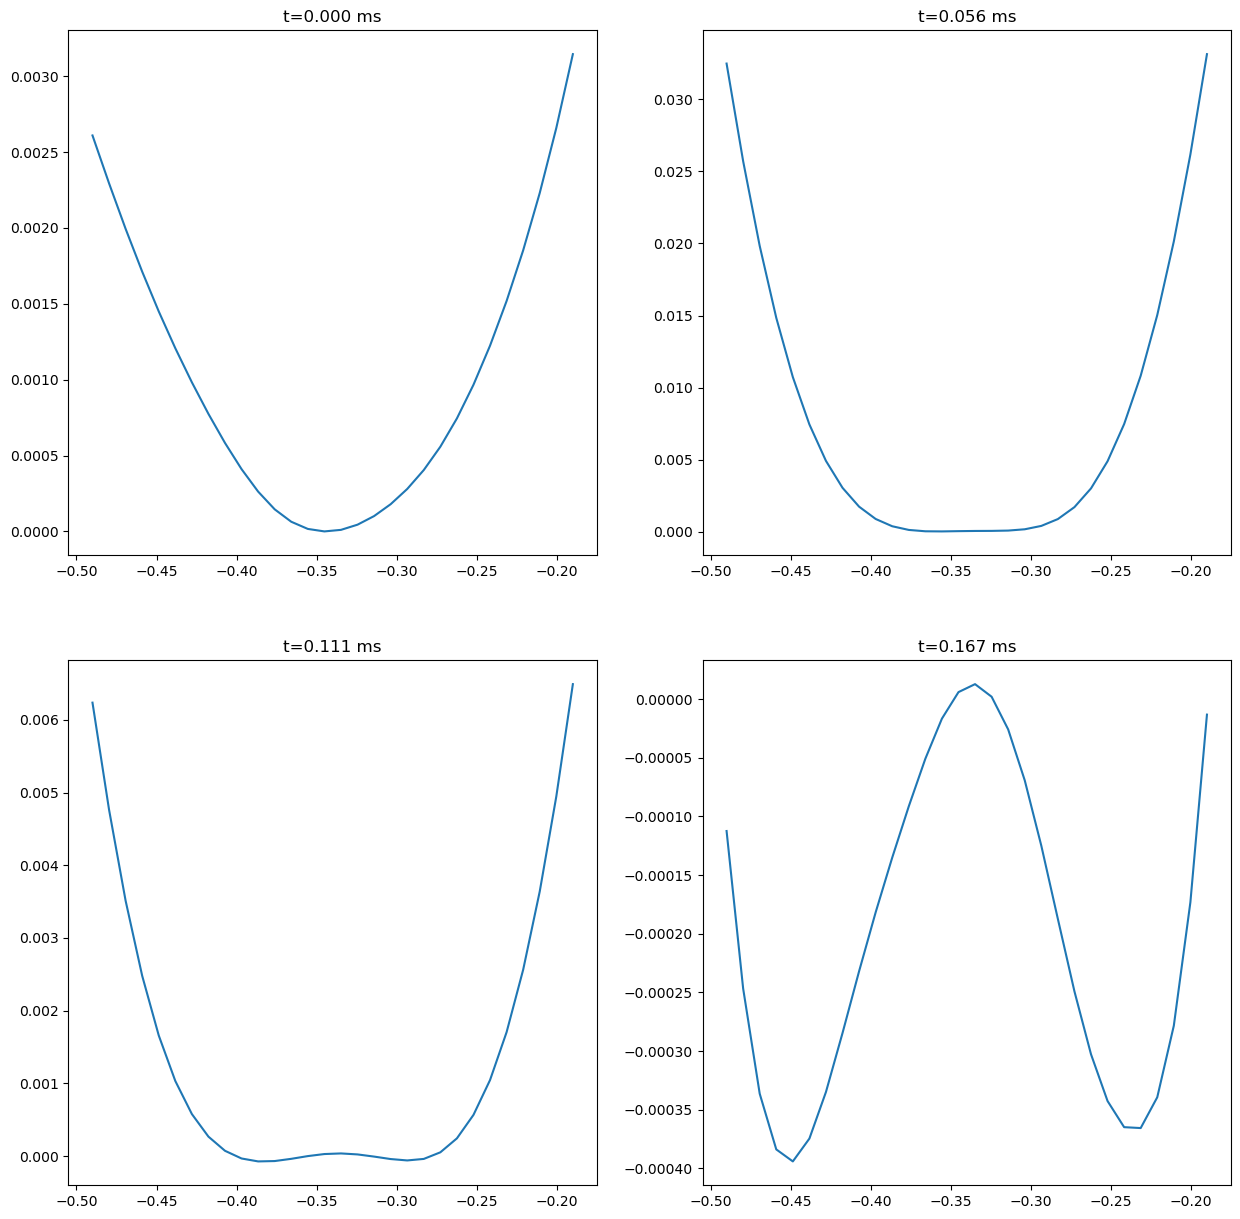

In [28]:
# 可视化势场随时间变化
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
cnt = 0
ax = ax.reshape(ax.size)
x0=-0.34
for i, opt in enumerate(V):
    if i % 13 == 0:
        xspan = np.linspace(x0-0.15, x0+0.15, 30)
        bowtie.potential_curvature_x(opt, xspan, ax=ax[cnt])
        ax[cnt].set_title('t=%.3f ms' % (T[i]*1000))
        # ax[cnt].set_xlabel("x")
        cnt += 1

In [29]:
0.1666e-4 * (0.06/0.5)**(2/3)

4.053179409850114e-06

[ 6.44182081e-04 -1.53914070e-01 -1.14772118e+00  1.93212788e+02]


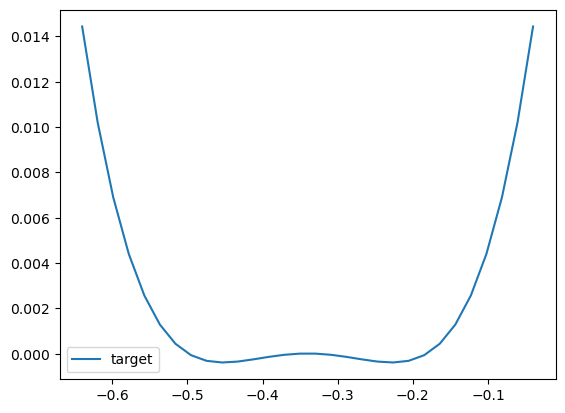

In [30]:
a, b, d = shuttle_protocols.split_sta_palmero(np.linspace(0, 1, 40), f0=0.06)


idx=-1
v, a, b = V[idx], a[idx], b[idx]
x0=-0.34
xspan = np.linspace(x0-0.3, x0+0.3, 30)
# bowtie.potential_curvature_x(v, xspan, label='generated potential')
# plt.vlines(x=x0, ymin=-0.1, ymax=0)
poly = bowtie.x_te(v, bowtie.rf_null_point(x0))
y0=bowtie.potential(v, bowtie.rf_null_point(x0))
func = lambda x, poly: y0+poly[0]*(x-x0)+poly[1]*(x-x0)**2/2+poly[2]*(x-x0)**3/6+poly[3]*(x-x0)**4/24
# plt.plot(xspan, func(xspan, poly), label='potential based on Taylor expansion')
plt.plot(xspan, func(xspan, np.array([0, a, 0, b])), label='target')
plt.legend()
print(poly)

In [31]:
interp=ndsplines.make_interp_spline(T*1e4, V)
nT = np.linspace(0, T.max()*1e4, int(1e2))
nV = interp(nT)

In [32]:
# 将电压文件导出

import pandas as pd
from tqdm import tqdm

def export_waveform(T, V, name):
    clms = ["T"] + ["L"+str(i) for i in range(1, 25)] + ["R"+str(i) for i in range(1, 25)]
    df = pd.DataFrame(columns=clms)
    df["T"]=T
    for i, idx in enumerate([42, 41, 40, 39, 38, 7, 11, 6, 37, 36]):
        df["L"+str(10-i)]=V[:, idx]
    for i, idx in enumerate([28, 27, 26, 25, 24, 3, 9, 2, 23, 22]):
        df["L"+str(i+15)]=V[:, idx]
    df["L12"]=V[:, 14]
    df["L13"]=V[:, 13]
    for i, idx in enumerate([35, 34, 5, 10, 4, 33, 32, 31, 30, 29]):
        df["R"+str(i+1)] = V[:, idx]
    # d["R12"]=160
    for i, idx in enumerate([21, 20, 1, 8, 0, 19, 18, 17, 16, 15]):
        df["R"+str(24-i)] = V[:, idx]
    
    df.to_excel("waveforms/"+name+".xlsx")
    return df


export_waveform(nT, nV, "split_demo_left_tilded")

,T,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,R15,R16,R17,R18,R19,R20,R21,R22,R23,R24
0,0.000000,-0.531690,-0.075671,0.071930,-0.083075,-0.163520,-0.064199,0.202629,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
1,0.016835,-0.531548,-0.075710,0.071664,-0.082939,-0.163257,-0.064570,0.203019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
2,0.033670,-0.531712,-0.075523,0.071392,-0.082955,-0.162926,-0.064725,0.203091,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
3,0.050505,-0.531806,-0.075369,0.071090,-0.082970,-0.162601,-0.064903,0.203213,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
4,0.067340,-0.531455,-0.075502,0.070736,-0.082833,-0.162355,-0.065339,0.203752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.599327,-0.712570,-0.047642,-0.081636,0.195403,0.387081,-0.458571,0.327455,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
96,1.616162,-0.721686,-0.037997,-0.084294,0.185988,0.386808,-0.450460,0.319483,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
97,1.632997,-0.729902,-0.029270,-0.086831,0.177541,0.386720,-0.443305,0.312440,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2
98,1.649832,-0.737339,-0.021324,-0.089335,0.169945,0.386893,-0.437048,0.306251,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2


# 运动加热率模拟

In [34]:
tspan, y = bowtie.split_motion(0.34, T[-1], V)

KeyboardInterrupt: 

Text(0, 0.5, 'z(mm)')

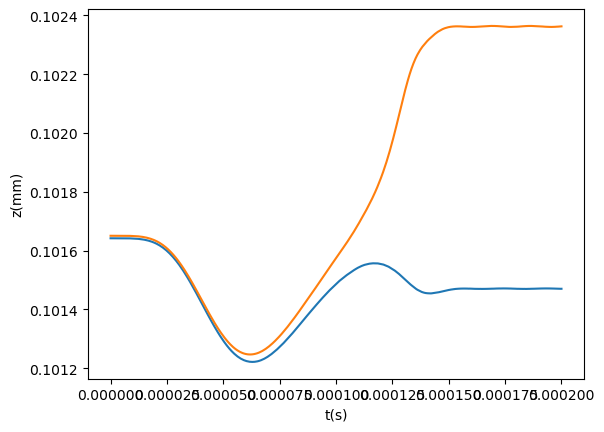

In [55]:
plt.plot(tspan, y[2])
plt.plot(tspan, y[5])
plt.xlabel('t(s)')
plt.ylabel('z(mm)')

Text(0, 0.5, 'x(mm)')

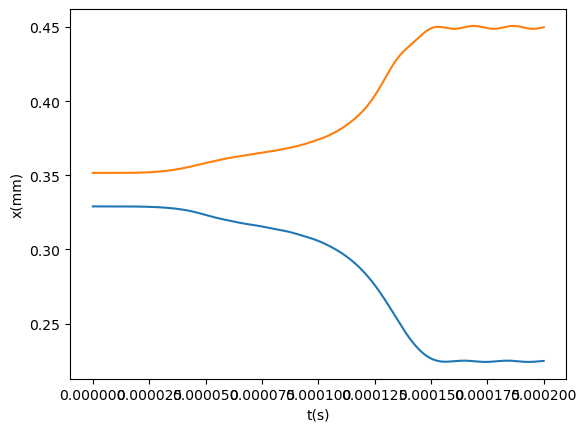

In [56]:
plt.plot(tspan, y[0])
plt.plot(tspan, y[3])
plt.xlabel('t(s)')
plt.ylabel('x(mm)')

In [59]:
heating0 = bowtie.heating_one_ion(tspan, T, y[0], freq=0.15e6*2*np.pi)
heating1 = bowtie.heating_one_ion(tspan, T, y[3], freq=0.15e6*2*np.pi)
heating0, heating1

(229.4427576674148, 1225.6349769973651)